# Problema de detección de anomalías

## Identificación de transacciones fraudulentas en tarjetas

### Descripción del problema:

Uno de los problemas en la financiación al consumo es el fraude en tarjetas, dinero que es cargado a los clientes por productos que ellos no han adquirido. Esto es un problema importante para el sector financiero ya que, además de las pérdidas monetarias, disminuye la fidelización de los clientes. Hay que recordar que el sistema monetario actual se basa en la confianza, y el dinero es lo primero que escapa cuando no hay confianza en las entidades.

Los datos de este problema provienen de la siguiente dirección de Kaggle:

**Url:** https://www.kaggle.com/mlg-ulb/creditcardfraud

### Descripción del dataset:

Cuenta con un total de **30 variables predictoras X** y una **variable continua a predecir Y**.

El número total de muestras es de 284.807 transacciones.

El dataset contiene transacciones de tarjetas realizadas en septiembre de 2013 por entidades europeas.
Estas transacciones ocurrieron en dos días, produciéndose un total de 492 transacciones fraudulentas de un total de 284.807.
El dataset está altamente desbalanceado, la clase positiva (fraudes) sólo es un 0.172 % del total de transacciones.

**Información de las variables:**

**Variable dependiente Y:**

La variable 'Class' es la respuesta, indica si esa transacción es fraudulenta (1) o no es fraudulenta (0).

**Variables independientes X:**

Todas las variables en este dataset son numericas. Dos de ellas son 'Time' y 'Amount', las cuales son variables originales. El resto, son resultado de una transformación PCA, siendo V1-V28 las componentes principales. Por motivos de confidencialidad no se proporcionan las variables originales ni más información sobre los datos. 

* 'Time': segundos entre cada transacción y la primera transacción del dataset
* 'Amount': unidades monetarias de la transacción
* Variables 'V1-V28': componentes principales de una transformación de variables utilizando PCA

### Planteamiento del problema

#### Contexto :

En un escenario del mundo real, los algoritmos no supervisados se utilizan en estos casos para filtrar del total de transacciones cuáles son anómalas. A veces se utilizan reglas de negocio para hacer ese filtrado, pero muchas veces esas reglas son muy difíciles de formular. Ya que no es viable analizar todas las transacciones, un modelo no supervisado que filtre comportamientos extraños es muy útil para realizar una primera criba. Para ello se hallan características de cada transacción (X) y con detectores de anomalías se estima cuáles son anómalas y cuáles no. 

Posteriormente, se auditan todas esas transacciones anómalas y se obtienen las etiquetas reales (Y). Se halla qué transacciones son fraudulentas (Y=1) y cuales no (Y=0).

Llegado un punto, la entidad financiera tiene datos etiquetados (X,Y) que puede utilizar para realizar un clasificador de aprendizaje supervisado.  

#### Planteamiento de este ejemplo:

En este caso tenemos las características de cada transacción (X) y la etiqueta indicando si son fraude o no (Y). Podríamos realizar directamente un clasificador de aprendizaje supervisado, pero el objetivo es que tengáis una aproximación a cómo de útil puede ser un modelo de detección de anomalías en pasos previos.

Voy a suponer que no existe una etiqueta (Y), voy a realizar un modelo de detección de anomalías sólamente con las características (X). Hallaré qué transacciones obtengo como anómalas y luego compararé con las etiquetas reales (Y). De este modo podremos ver cómo un detector de anomalías podría servir en ese primer filtrado.

# Carga de librerías:

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
new_style = {'grid': False}
plt.rc('axes', **new_style)

import seaborn as sns

from sklearn.neighbors import LocalOutlierFactor
import sklearn.metrics as metrics

import scikitplot as skplt # ! pip install scikit-plot

# Definición de funciones: 

In [3]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def repre_matriz_confusion(matriz):
    df_matriz_confusion = pd.DataFrame(matriz,
                     ['True Normal','True Fraud'],
                     ['Pred Normal','Pred Fraud'])
    plt.figure(figsize = (8,4))
    sns.set(font_scale=1.4)
    plt.title(u'Matriz de confusión')
    _ = sns.heatmap(df_matriz_confusion, annot=True, annot_kws={"size": 16}, fmt='g')
    
def reporting_modelo(y_reales, y_clase):
    matriz_confusion = metrics.confusion_matrix(y_reales, y_clase)
    roc_auc = metrics.roc_auc_score(y_reales, y_clase)
    metrica_f1 = metrics.f1_score(y_reales, y_clase)
    print(u'La AUC de la ROC es de: {}'.format(round(roc_auc,2)))
    print(u'La F1 es de: {}'.format(round(metrica_f1,2)))
    print("\nAccuracy\t{}".format(round(metrics.accuracy_score(y_reales, y_clase),3)))  
    print("Sensitividad\t{}".format(round(metrics.recall_score(y_reales, y_clase),3)))
    print(u"Precisión\t{}".format(round(metrics.precision_score(y_reales, y_clase),3)))   
    repre_matriz_confusion(matriz_confusion)
    
def repres_doble_hist(y_prob_pos, y_prob_neg):
    
    fig = plt.figure(figsize=(20,10))
    ax = sns.distplot(y_prob_pos,norm_hist=True, bins=30, hist=False,
    label='', kde_kws={"color": "r", "lw": 5})  
    ax2 = ax.twinx()
    sns.distplot(y_prob_neg,norm_hist=True ,ax=ax2, bins=30, hist=False,
    label='', kde_kws={"color": "g", "lw": 2}) 
    sns.set_style("whitegrid", {'axes.grid' : False})
    ax.figure.legend(['Clase fraudulenta', 'Clase no fraudulenta'])
    new_style = {'grid': False}
    plt.rc('axes', **new_style)
    plt.title('Representación de las probabilidades asignadas a ambas clases')
    plt.show()

# Lectura de datos:

In [4]:
XY = pd.read_csv('creditcard.csv')

In [5]:
print(u'- El número de filas en el dataset es: {}'.format(XY.shape[0]))
print(u'- El número de columnas en el dataset es: {}'.format(XY.shape[1]))
print(u'- Los nombres de las variables son: {}'.format(list(XY.columns)))
XY[:2]

- El número de filas en el dataset es: 284807
- El número de columnas en el dataset es: 31
- Los nombres de las variables son: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [8]:
XY.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
XY[XY.Class != 0].describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,...,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.0
mean,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321,1.0
std,47835.365138,6.783687,4.291216,7.110937,2.873318,5.372468,1.858124,7.206773,6.797831,2.500896,...,3.869304,1.494602,1.579642,0.515577,0.797205,0.471679,1.376766,0.547291,256.683288,0.0
min,406.000000,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,0.000000,1.0
25%,41241.500000,-6.036063,1.188226,-8.643489,2.373050,-4.792835,-2.501511,-7.965295,-0.195336,-3.872383,...,0.041787,-0.533764,-0.342175,-0.436809,-0.314348,-0.259416,-0.020025,-0.108868,1.000000,1.0
50%,75568.500000,-2.342497,2.717869,-5.075257,4.177147,-1.522962,-1.424616,-3.034402,0.621508,-2.208768,...,0.592146,0.048434,-0.073135,-0.060795,0.088371,0.004321,0.394926,0.146344,9.250000,1.0
75%,128483.000000,-0.419200,4.971257,-2.276185,6.348729,0.214562,-0.413216,-0.945954,1.764879,-0.787850,...,1.244611,0.617474,0.308378,0.285328,0.456515,0.396733,0.826029,0.381152,105.890000,1.0
max,170348.000000,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,...,27.202839,8.361985,5.466230,1.091435,2.208209,2.745261,3.052358,1.779364,2125.870000,1.0


In [10]:
XY['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

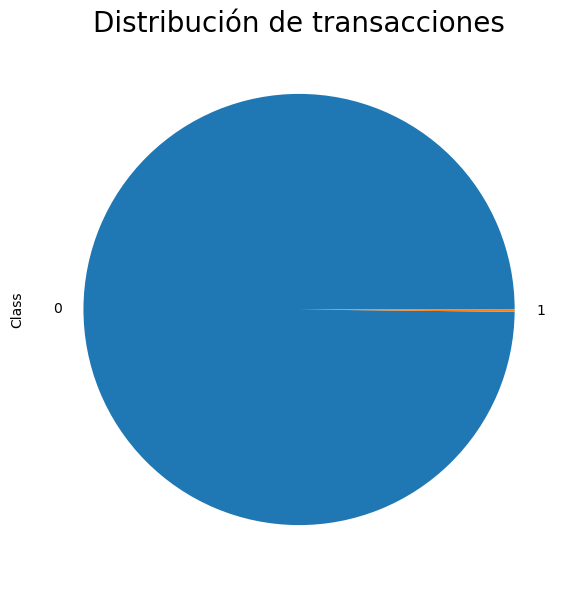

In [11]:
XY['Class'].value_counts().plot(kind='pie', figsize=(7,7))
_ = plt.title('Distribución de transacciones', fontsize=20)

Como vemos, las clases están muy desbalanceadas ya que apenas hay casos fraudulentos. 

# Division en features X + target Y 

In [12]:
X = XY.drop('Class', axis=1)
Y = XY['Class']

# Ajuste del modelo de detección de anomalías a X

Voy a utilizar el método Local Outlier Factor. Este método sólo se fija en los vecinos locales de cada punto por lo que vamos a ajustar el modelo a todos los datos X. 

Un parámetro que se puede ir cambiando es el **número de vecinos**. A menor número más se ajusta el modelo.

In [13]:
clf=LocalOutlierFactor(n_neighbors=10, 
                        algorithm='auto', 
                        leaf_size=30,
                        metric='minkowski', 
                        p=2, 
                        metric_params=None, 
                        n_jobs=-1,
                        novelty=False)

In [14]:
%%time
clf.fit(X)

CPU times: total: 17min 15s
Wall time: 2min 21s


LocalOutlierFactor(n_jobs=-1, n_neighbors=10)

# Detección de anomalías

El modelo nos proporciona lo que se denominan factores de anomalías negativos. Cuanto más alto es este valor, más normal es el punto. Es decir, si queremos quedarnos con el 2 % de puntos más anómalos, debemos quedarnos con el 2 % de valores más bajo. 

In [15]:
factores_lof = clf.negative_outlier_factor_
factores_lof

array([-1.19618609, -1.15222336, -1.61787169, ..., -1.32806678,
       -1.24067802, -1.75327498])

In [16]:
len(factores_lof)

284807

In [33]:
np.max(factores_lof)

-0.9032395034554842

In [35]:
np.percentile(factores_lof,0.99)

-1.640519202202555

In [38]:
np.percentile(factores_lof,0.999)

-1.6369802873380013

In [41]:
np.percentile(factores_lof,0.50)

-1.9016447361073652

In [40]:
np.percentile(factores_lof,0.25)

-2.2225970126065717

In [34]:
np.min(factores_lof)

-32489844377.6567

Ponemos el umbral en un 2 % para tener margen.

In [31]:
Y_pred_clase = factores_lof.copy()

Y_pred_clase[factores_lof>=np.percentile(factores_lof,2.)] = 0
Y_pred_clase[factores_lof<np.percentile(factores_lof,2.)] = 1

La AUC de la ROC es de: 0.67
La F1 es de: 0.06

Accuracy	0.98
Sensitividad	0.358
Precisión	0.031


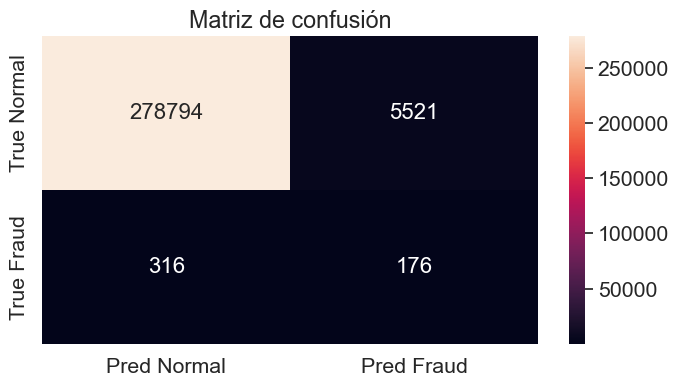

In [32]:
 reporting_modelo(Y, Y_pred_clase) 

Como vemos, con un dos por ciento de la muestra detectada como fraude, detectamos más del 50 % de las transacciones fraudulentas.

## Representación de las probabilidades:

Normalizo los factores al rango (0,1) para obtener una estimación de probabilidades:

In [42]:
Y_probs = NormalizeData(factores_lof)
Y_pred_prob_pos = NormalizeData(factores_lof)[np.where(Y == 1)]
Y_pred_prob_neg = NormalizeData(factores_lof)[np.where(Y == 0)]

C:\Users\jmmor\AppData\Local\Temp\ipykernel_17700\2179684527.py:27: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y_prob_pos,norm_hist=True, bins=30, hist=False,
C:\Users\jmmor\AppData\Local\Temp\ipykernel_17700\2179684527.py:30: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distpl

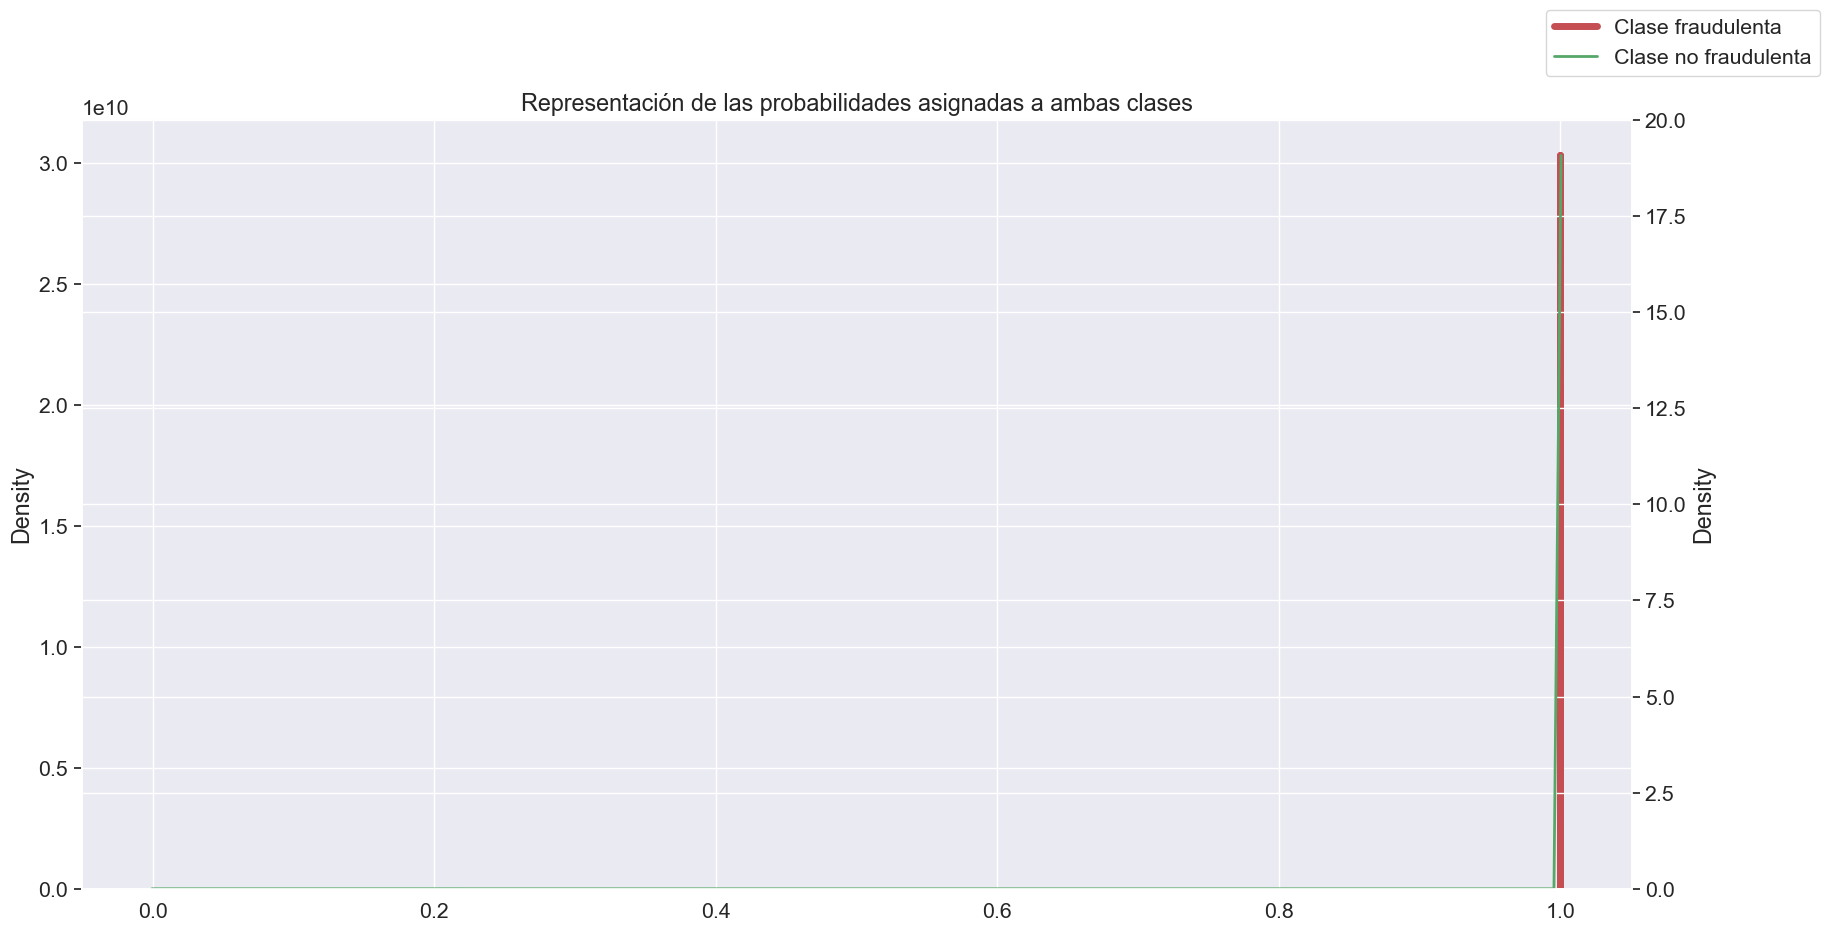

In [43]:
repres_doble_hist(Y_pred_prob_pos, Y_pred_prob_neg)

El modelo asigna a la clase fraudulenta valores centrados en el 1 (anómalos). Por otro lado, la clase no fraudulenta tiene muchos valores en 0s y en 1s. 